In [ ]:
# Graph Construction With Top 20 Featues (Target Column: Visual)

In [1]:
!pip install torch

!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.9.0+cu111.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.9.0+cu111.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-1.9.0+cu111.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-1.9.0+cu111.html
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-1.9.0+cu111.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl size=3938489 sha256=6c46b27d87589bec95a1717b676c3eccdd0c2af4a257aae9adf674cbb7704661
  Stored in directory: /root/.cache/pip/wheels/92/f1/2b/3b46d54b134259f58c8363568569053248040859b1a145b3ce
Successfully built torch-scatter
Looking in links: https://data.pyg.org/whl/torch-1.9.0+cu111.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp310-cp310-linux_x86_64.whl size=2729580 sha256=45444dfabc73bb02762f40f962c2f4270b5aa75288afad83a7b7bf6657a15b75
  Stored in directory: /root/.cache/pip/wheels/c9/dd/0f/a6a16f9f3b0236733d257b4b4ea91b548b984a341ed3b8f38c
Successfully b

In [2]:
import os
count = 0
for root, folders, filenames in os.walk('/kaggle/input'):
   print(root, folders)

/kaggle/input ['all-based-sensory-data']
/kaggle/input/all-based-sensory-data []


In [3]:
import torch
import pandas as pd
import numpy as np

file_path = "/kaggle/input/all-based-sensory-data/All-based-Sensory.csv"
data = pd.read_csv(file_path)

target_column = 'Visual'

non_numeric_columns = ['Image'] 
data = data.drop(columns=non_numeric_columns)



print(data.describe())
print(data.isin([np.inf, -np.inf]).sum())

data.replace([np.inf, -np.inf], np.nan, inplace=True)

data.dropna(inplace=True)

data.fillna(data.mean(), inplace=True)

print(data.isna().sum())
print(data.describe())
print(data.isin([np.inf, -np.inf]).sum())

X = data.drop(columns=[target_column])
y = data[target_column]

             Area    PA_ratio    Solidity  Circularity  EquivDiameter  \
count  450.000000  450.000000  450.000000   450.000000     450.000000   
mean    12.331111    0.669406    0.803765          inf       3.369617   
std     19.569172    0.390348    0.206400          NaN       2.087060   
min      1.000000    0.000000    0.239752     0.089574       1.128379   
25%      3.000000    0.333333    0.655982     1.075594       1.954410   
50%      6.000000    0.819516    0.833333     2.317325       2.763953   
75%     14.750000    0.960925    1.000000    37.699112       4.333147   
max    228.000000    1.167658    1.000000          inf      17.038152   

       ConvexArea      Extent  FilledArea  Major axis length  \
count  450.000000  450.000000  450.000000         450.000000   
mean    22.893333    0.637418   12.466667           5.955634   
std     56.968535    0.257433   20.230630           5.475747   
min      1.000000    0.134115    1.000000           0.000000   
25%      3.000000    0

/opt/conda/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


# Graph Convolutional Network (GCN)

In [4]:
import torch
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

target_column = 'Visual'

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

encoder = OneHotEncoder(sparse=False)
y_encoded = encoder.fit_transform(y.values.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

num_nodes = X_train_tensor.shape[0]
edge_index = torch.combinations(torch.arange(num_nodes), r=2).t()

print("----------------")
print("Nodes: ")
print(num_nodes)
print("Edge: ")
print(edge_index)
print("----------------")
print("Edges: ", edge_index.shape[1])
print("----------------")

data = Data(x=X_train_tensor, edge_index=edge_index, y=y_train_tensor)

num_train = int(0.8 * num_nodes)
num_val = int(0.1 * num_nodes)
num_test = num_nodes - num_train - num_val

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[:num_train] = True
val_mask[num_train:num_train + num_val] = True
test_mask[num_train + num_val:] = True

data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, 16)
        self.conv2 = GCNConv(16, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GCN(in_channels=X_train_tensor.shape[1], out_channels=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    logits, accs = model(data), []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

loss_values = []
train_acc_values = []
val_acc_values = []
test_acc_values = []

for epoch in range(1, 201):
    loss = train()
    train_acc, val_acc, test_acc = test()
    loss_values.append(loss)
    train_acc_values.append(train_acc)
    val_acc_values.append(val_acc)
    test_acc_values.append(test_acc)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


----------------
Nodes: 
284
Edge: 
tensor([[  0,   0,   0,  ..., 281, 281, 282],
        [  1,   2,   3,  ..., 282, 283, 283]])
----------------
Edges:  40186
----------------
Epoch: 001, Loss: 1.2009, Train Acc: 0.3260, Val Acc: 0.5357, Test Acc: 0.4828
Epoch: 002, Loss: 0.9384, Train Acc: 0.3656, Val Acc: 0.5357, Test Acc: 0.4828
Epoch: 003, Loss: 0.6934, Train Acc: 0.6784, Val Acc: 0.4643, Test Acc: 0.5172
Epoch: 004, Loss: 0.7331, Train Acc: 0.6784, Val Acc: 0.4643, Test Acc: 0.5172
Epoch: 005, Loss: 0.7194, Train Acc: 0.6784, Val Acc: 0.4643, Test Acc: 0.5172
Epoch: 006, Loss: 0.7100, Train Acc: 0.6784, Val Acc: 0.4643, Test Acc: 0.5172
Epoch: 007, Loss: 0.6954, Train Acc: 0.6784, Val Acc: 0.4643, Test Acc: 0.5172
Epoch: 008, Loss: 0.7327, Train Acc: 0.6784, Val Acc: 0.4643, Test Acc: 0.5172
Epoch: 009, Loss: 0.7491, Train Acc: 0.6784, Val Acc: 0.4643, Test Acc: 0.5172
Epoch: 010, Loss: 0.7267, Train Acc: 0.6784, Val Acc: 0.4643, Test Acc: 0.5172
Epoch: 011, Loss: 0.7385, Train A

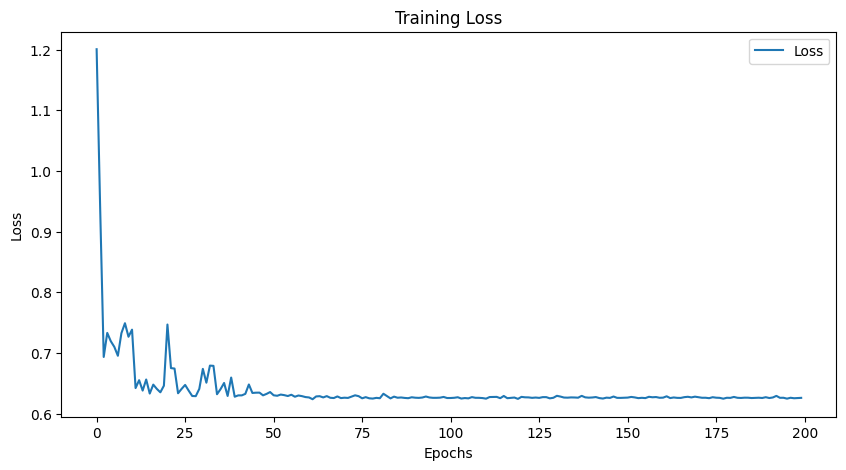

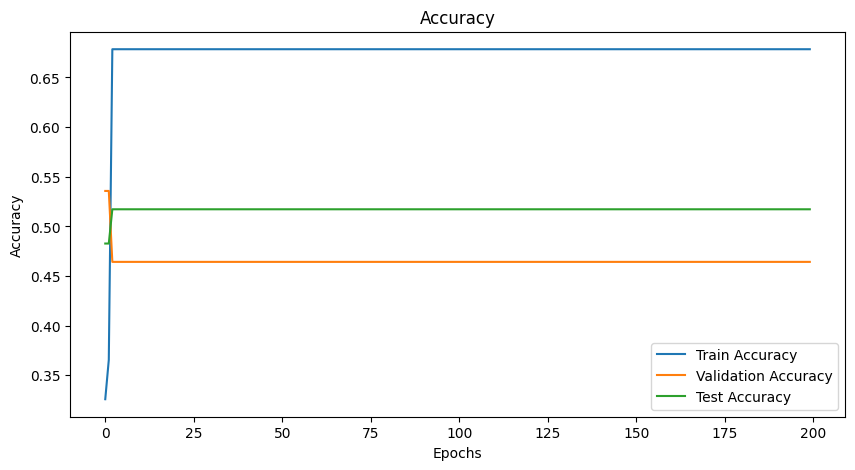

In [5]:
import torch
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(loss_values, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_acc_values, label='Train Accuracy')
plt.plot(val_acc_values, label='Validation Accuracy')
plt.plot(test_acc_values, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()


# Graph Attention Network (GAT)

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_heads):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=num_heads)
        self.conv2 = GATConv(hidden_channels * num_heads, out_channels, heads=num_heads)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GAT(in_channels=X_train_tensor.shape[1], hidden_channels=8, out_channels=2, num_heads=8)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    logits, accs = model(data), []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

loss_values = []
train_acc_values = []
val_acc_values = []
test_acc_values = []

for epoch in range(1, 201):
    loss = train()
    train_acc, val_acc, test_acc = test()
    loss_values.append(loss)
    train_acc_values.append(train_acc)
    val_acc_values.append(val_acc)
    test_acc_values.append(test_acc)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Loss: 4.3863, Train Acc: 0.0000, Val Acc: 0.0000, Test Acc: 0.0000
Epoch: 002, Loss: 5.7649, Train Acc: 0.0661, Val Acc: 0.0000, Test Acc: 0.0000
Epoch: 003, Loss: 1.7061, Train Acc: 0.6784, Val Acc: 0.4643, Test Acc: 0.5172
Epoch: 004, Loss: 1.3359, Train Acc: 0.6784, Val Acc: 0.4643, Test Acc: 0.5172
Epoch: 005, Loss: 1.1326, Train Acc: 0.6784, Val Acc: 0.4643, Test Acc: 0.5172
Epoch: 006, Loss: 0.7914, Train Acc: 0.6784, Val Acc: 0.4643, Test Acc: 0.5172
Epoch: 007, Loss: 0.8246, Train Acc: 0.6784, Val Acc: 0.4643, Test Acc: 0.5172
Epoch: 008, Loss: 0.7266, Train Acc: 0.6784, Val Acc: 0.4643, Test Acc: 0.5172
Epoch: 009, Loss: 0.9540, Train Acc: 0.6784, Val Acc: 0.4643, Test Acc: 0.5172
Epoch: 010, Loss: 0.6996, Train Acc: 0.6740, Val Acc: 0.4643, Test Acc: 0.5172
Epoch: 011, Loss: 0.8544, Train Acc: 0.6476, Val Acc: 0.4643, Test Acc: 0.5172
Epoch: 012, Loss: 0.9707, Train Acc: 0.6432, Val Acc: 0.4643, Test Acc: 0.5172
Epoch: 013, Loss: 0.8581, Train Acc: 0.6652, Val Acc

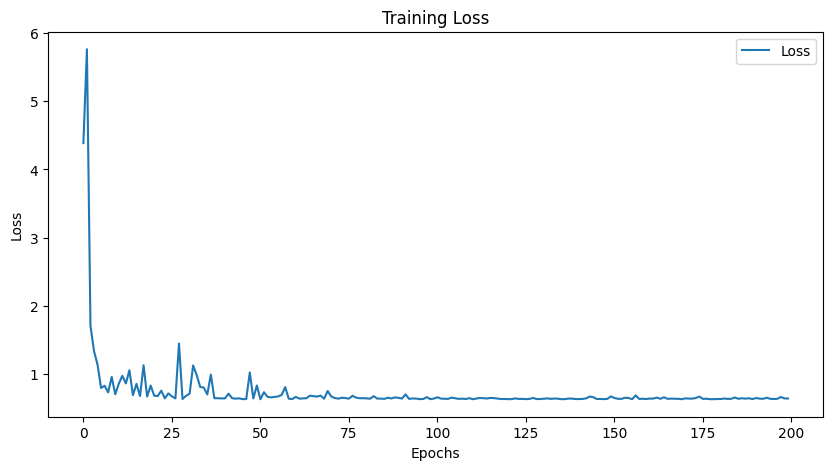

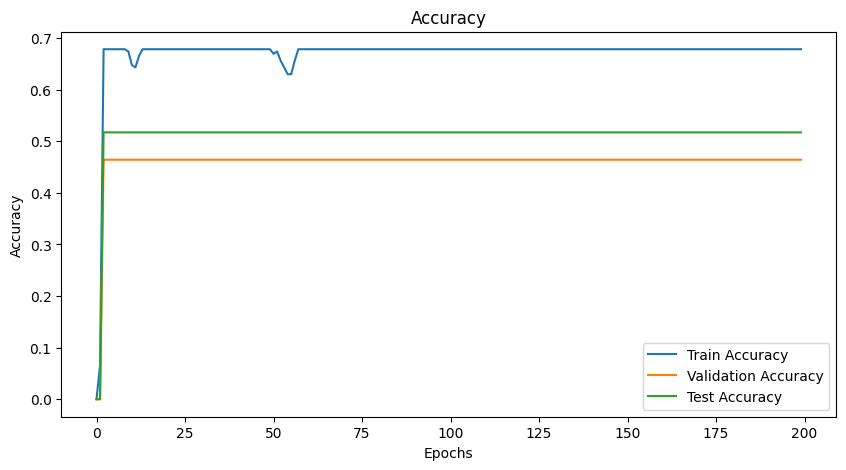

In [7]:
import torch
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(loss_values, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_acc_values, label='Train Accuracy')
plt.plot(val_acc_values, label='Validation Accuracy')
plt.plot(test_acc_values, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()


# Graph Sample & Aggregate (GraphSAGE)

In [8]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


In [9]:
import torch
from torch_geometric.data import Data

data = Data(x=X_train_tensor, edge_index=edge_index, y=y_train_tensor)

num_train = int(0.8 * num_nodes)
num_val = int(0.1 * num_nodes)
num_test = num_nodes - num_train - num_val

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[:num_train] = True
val_mask[num_train:num_train + num_val] = True
test_mask[num_train + num_val:] = True

data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

import torch.nn.functional as F

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GraphSAGE(in_channels=X_train_tensor.shape[1], hidden_channels=16, out_channels=2) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    logits, accs = model(data.x, data.edge_index), []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

loss_values = []
train_acc_values = []
val_acc_values = []
test_acc_values = []

for epoch in range(1, 201):
    loss = train()
    train_acc, val_acc, test_acc = test()
    loss_values.append(loss)
    train_acc_values.append(train_acc)
    val_acc_values.append(val_acc)
    test_acc_values.append(test_acc)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')


Epoch: 001, Loss: 0.6618, Train Acc: 0.6784, Val Acc: 0.4643, Test Acc: 0.5172
Epoch: 002, Loss: 0.6043, Train Acc: 0.6784, Val Acc: 0.4643, Test Acc: 0.5172
Epoch: 003, Loss: 0.5913, Train Acc: 0.6872, Val Acc: 0.4643, Test Acc: 0.5172
Epoch: 004, Loss: 0.5664, Train Acc: 0.7048, Val Acc: 0.5357, Test Acc: 0.5517
Epoch: 005, Loss: 0.5635, Train Acc: 0.7048, Val Acc: 0.5357, Test Acc: 0.5862
Epoch: 006, Loss: 0.5381, Train Acc: 0.7137, Val Acc: 0.5357, Test Acc: 0.6207
Epoch: 007, Loss: 0.5124, Train Acc: 0.7225, Val Acc: 0.5714, Test Acc: 0.6552
Epoch: 008, Loss: 0.5299, Train Acc: 0.7753, Val Acc: 0.6429, Test Acc: 0.6552
Epoch: 009, Loss: 0.4968, Train Acc: 0.7841, Val Acc: 0.6429, Test Acc: 0.6552
Epoch: 010, Loss: 0.5055, Train Acc: 0.7974, Val Acc: 0.6429, Test Acc: 0.6552
Epoch: 011, Loss: 0.5134, Train Acc: 0.8062, Val Acc: 0.6429, Test Acc: 0.6207
Epoch: 012, Loss: 0.4937, Train Acc: 0.8062, Val Acc: 0.6429, Test Acc: 0.6207
Epoch: 013, Loss: 0.4753, Train Acc: 0.8018, Val Acc

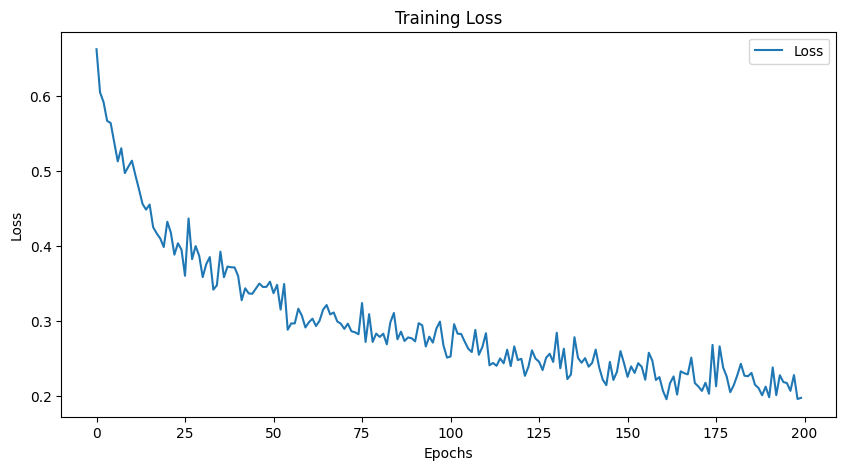

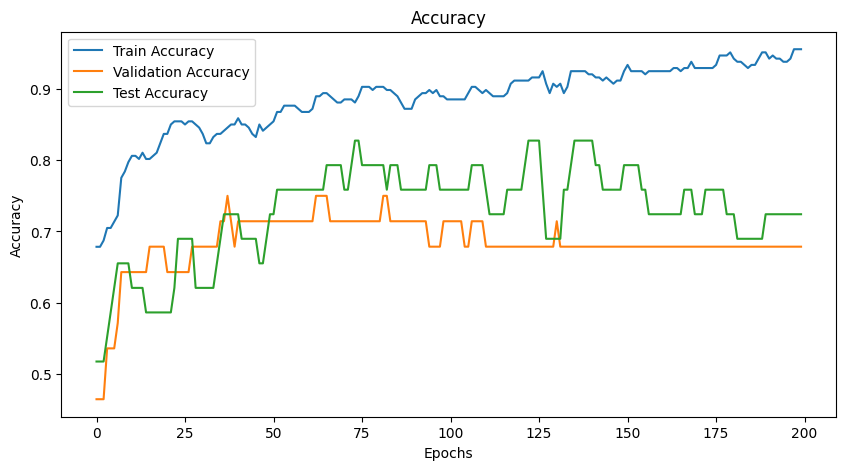

In [10]:
import torch
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(loss_values, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_acc_values, label='Train Accuracy')
plt.plot(val_acc_values, label='Validation Accuracy')
plt.plot(test_acc_values, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()


# Variational Graph Autoencoder (VGAE)

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class VGAEEncoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(VGAEEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return x

class VGAE(torch.nn.Module):
    def __init__(self, encoder):
        super(VGAE, self).__init__()
        self.encoder = encoder

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, x, edge_index):
        z = self.encoder(x, edge_index)
        mu = z
        logvar = z
        z = self.reparameterize(mu, logvar)
        return F.log_softmax(z, dim=1), mu, logvar


In [12]:
import torch

encoder = VGAEEncoder(in_channels=X_train_tensor.shape[1], hidden_channels=16, out_channels=2)
model = VGAE(encoder)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out, mu, logvar = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    loss += kl_loss
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    logits, _, _ = model(data.x, data.edge_index)
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

loss_values = []
train_acc_values = []
val_acc_values = []
test_acc_values = []

for epoch in range(1, 201):
    loss = train()
    train_acc, val_acc, test_acc = test()
    loss_values.append(loss)
    train_acc_values.append(train_acc)
    val_acc_values.append(val_acc)
    test_acc_values.append(test_acc)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Loss: 291.5854, Train Acc: 0.6784, Val Acc: 0.4643, Test Acc: 0.5172
Epoch: 002, Loss: 17.7312, Train Acc: 0.6784, Val Acc: 0.4643, Test Acc: 0.5172
Epoch: 003, Loss: 19.8520, Train Acc: 0.6784, Val Acc: 0.4643, Test Acc: 0.5172
Epoch: 004, Loss: 38.9152, Train Acc: 0.6784, Val Acc: 0.4643, Test Acc: 0.5172
Epoch: 005, Loss: 99.8325, Train Acc: 0.6784, Val Acc: 0.4643, Test Acc: 0.5172
Epoch: 006, Loss: 78.4316, Train Acc: 0.5771, Val Acc: 0.5357, Test Acc: 0.4828
Epoch: 007, Loss: 26.3445, Train Acc: 0.3568, Val Acc: 0.5357, Test Acc: 0.4828
Epoch: 008, Loss: 15.6405, Train Acc: 0.3216, Val Acc: 0.5357, Test Acc: 0.4828
Epoch: 009, Loss: 32.5047, Train Acc: 0.3216, Val Acc: 0.5357, Test Acc: 0.4828
Epoch: 010, Loss: 5.2476, Train Acc: 0.3216, Val Acc: 0.5357, Test Acc: 0.4828
Epoch: 011, Loss: 25.3640, Train Acc: 0.3216, Val Acc: 0.5357, Test Acc: 0.4828
Epoch: 012, Loss: 26.5245, Train Acc: 0.3216, Val Acc: 0.5357, Test Acc: 0.4828
Epoch: 013, Loss: 17.1621, Train Acc: 0.

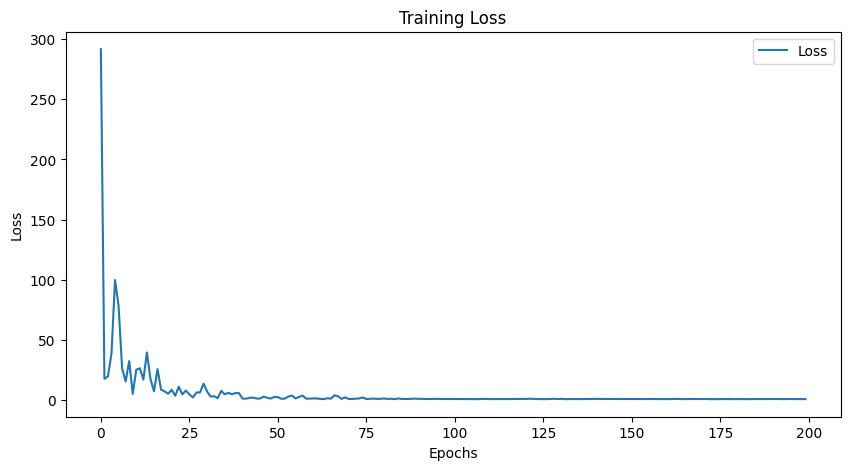

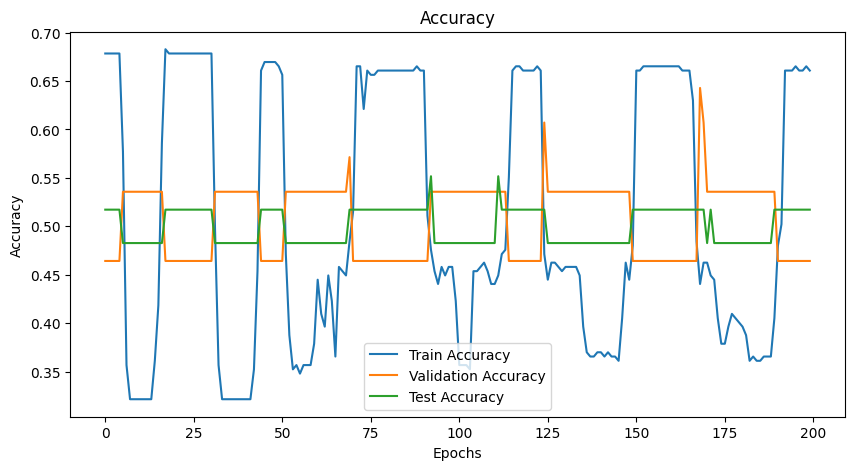

In [13]:
import torch
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(loss_values, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_acc_values, label='Train Accuracy')
plt.plot(val_acc_values, label='Validation Accuracy')
plt.plot(test_acc_values, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()


# Deep Graph Infomax (DGI)

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class DGI(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(DGI, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)


In [15]:
import torch.nn.functional as F

model = DGI(in_channels=X_train_tensor.shape[1], hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    logits = model(data.x, data.edge_index)
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

loss_values = []
train_acc_values = []
val_acc_values = []
test_acc_values = []

for epoch in range(1, 201):
    loss = train()
    train_acc, val_acc, test_acc = test()
    loss_values.append(loss)
    train_acc_values.append(train_acc)
    val_acc_values.append(val_acc)
    test_acc_values.append(test_acc)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')


Epoch: 001, Loss: 2.6919, Train Acc: 0.0132, Val Acc: 0.0000, Test Acc: 0.0000
Epoch: 002, Loss: 2.2137, Train Acc: 0.6784, Val Acc: 0.4643, Test Acc: 0.5172
Epoch: 003, Loss: 1.8046, Train Acc: 0.6784, Val Acc: 0.4643, Test Acc: 0.5172
Epoch: 004, Loss: 1.4732, Train Acc: 0.6784, Val Acc: 0.4643, Test Acc: 0.5172
Epoch: 005, Loss: 1.2151, Train Acc: 0.6784, Val Acc: 0.4643, Test Acc: 0.5172
Epoch: 006, Loss: 1.0235, Train Acc: 0.6784, Val Acc: 0.4643, Test Acc: 0.5172
Epoch: 007, Loss: 0.8904, Train Acc: 0.6784, Val Acc: 0.4643, Test Acc: 0.5172
Epoch: 008, Loss: 0.8034, Train Acc: 0.6784, Val Acc: 0.4643, Test Acc: 0.5172
Epoch: 009, Loss: 0.7461, Train Acc: 0.6784, Val Acc: 0.4643, Test Acc: 0.5172
Epoch: 010, Loss: 0.7057, Train Acc: 0.6784, Val Acc: 0.4643, Test Acc: 0.5172
Epoch: 011, Loss: 0.6760, Train Acc: 0.6784, Val Acc: 0.4643, Test Acc: 0.5172
Epoch: 012, Loss: 0.6569, Train Acc: 0.6784, Val Acc: 0.4643, Test Acc: 0.5172
Epoch: 013, Loss: 0.6494, Train Acc: 0.6784, Val Acc

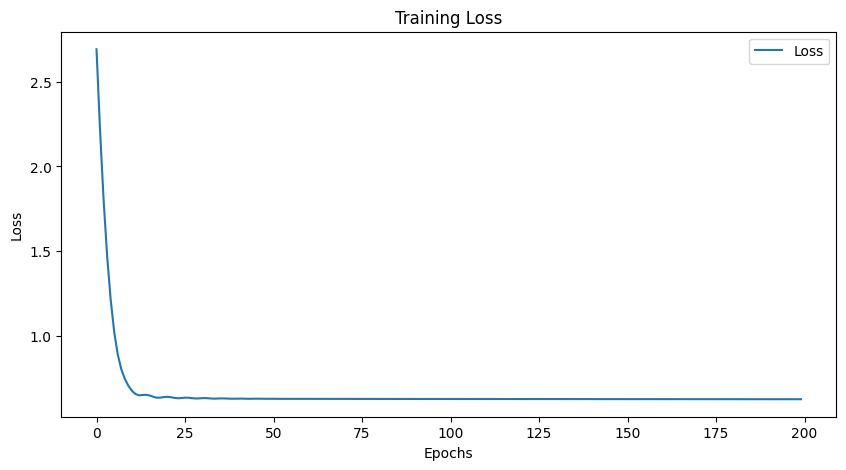

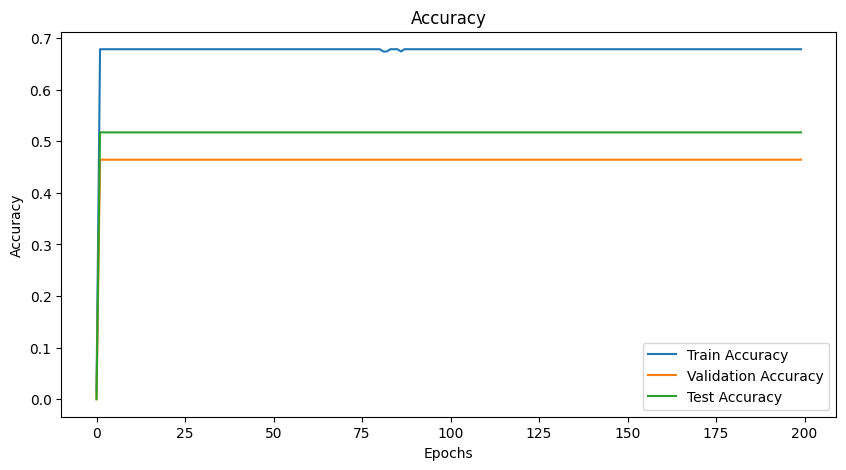

In [16]:
import torch
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(loss_values, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_acc_values, label='Train Accuracy')
plt.plot(val_acc_values, label='Validation Accuracy')
plt.plot(test_acc_values, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

# Graph Isomorphism Network (GIN)

In [17]:
from torch_geometric.nn import GINConv, global_add_pool
import torch

class GIN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GIN, self).__init__()
        self.conv1 = GINConv(torch.nn.Linear(in_channels, hidden_channels))
        self.conv2 = GINConv(torch.nn.Linear(hidden_channels, out_channels))

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GIN(in_channels=X_train_tensor.shape[1], hidden_channels=16, out_channels=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    logits = model(data.x, data.edge_index)
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

loss_values = []
train_acc_values = []
val_acc_values = []
test_acc_values = []

for epoch in range(1, 201):
    loss = train()
    train_acc, val_acc, test_acc = test()
    loss_values.append(loss)
    train_acc_values.append(train_acc)
    val_acc_values.append(val_acc)
    test_acc_values.append(test_acc)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')


Epoch: 001, Loss: 41.2133, Train Acc: 0.5463, Val Acc: 0.4643, Test Acc: 0.5172
Epoch: 002, Loss: 29.5104, Train Acc: 0.6432, Val Acc: 0.4643, Test Acc: 0.5172
Epoch: 003, Loss: 47.1585, Train Acc: 0.6476, Val Acc: 0.4643, Test Acc: 0.5172
Epoch: 004, Loss: 39.0024, Train Acc: 0.6564, Val Acc: 0.4643, Test Acc: 0.5172
Epoch: 005, Loss: 32.0217, Train Acc: 0.6476, Val Acc: 0.4643, Test Acc: 0.5172
Epoch: 006, Loss: 19.4063, Train Acc: 0.5374, Val Acc: 0.5357, Test Acc: 0.4828
Epoch: 007, Loss: 12.9796, Train Acc: 0.4714, Val Acc: 0.5357, Test Acc: 0.4828
Epoch: 008, Loss: 19.1855, Train Acc: 0.4141, Val Acc: 0.5357, Test Acc: 0.4828
Epoch: 009, Loss: 11.0055, Train Acc: 0.4846, Val Acc: 0.6786, Test Acc: 0.5172
Epoch: 010, Loss: 8.0385, Train Acc: 0.5463, Val Acc: 0.4643, Test Acc: 0.5172
Epoch: 011, Loss: 9.1409, Train Acc: 0.5463, Val Acc: 0.4643, Test Acc: 0.5172
Epoch: 012, Loss: 11.7350, Train Acc: 0.5419, Val Acc: 0.4643, Test Acc: 0.5172
Epoch: 013, Loss: 10.2660, Train Acc: 0.55

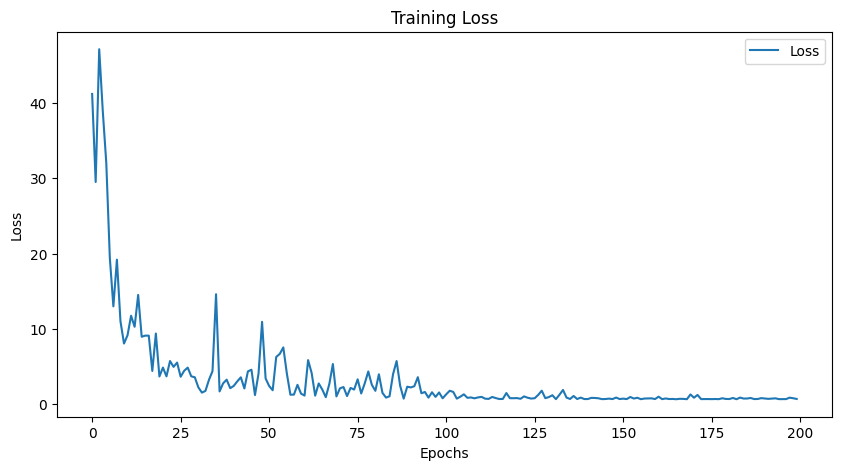

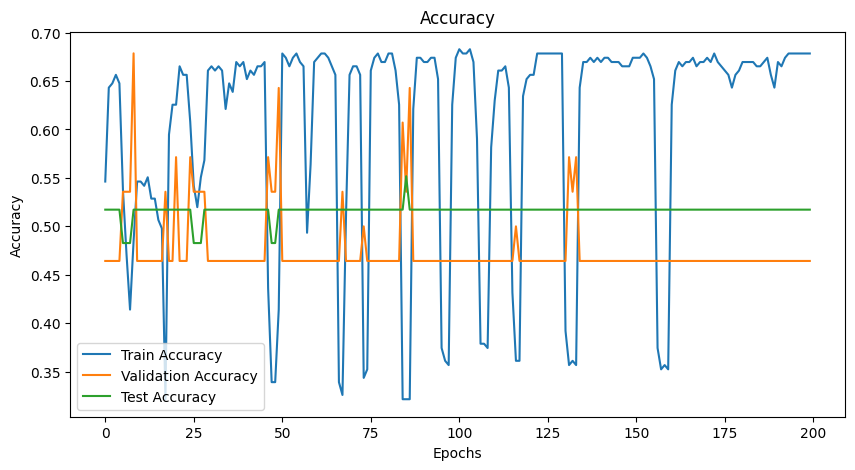

In [18]:
import torch
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(loss_values, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_acc_values, label='Train Accuracy')
plt.plot(val_acc_values, label='Validation Accuracy')
plt.plot(test_acc_values, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()